# Projet 8: Participez à la conception d'une voiture autonome

In [1]:
# Check core SDK version number
import azureml.core

print("SDK version:", azureml.core.VERSION)

SDK version: 1.38.0


In [2]:
from azureml.core import Workspace

ws = Workspace.from_config()
print(ws.name, ws.resource_group, ws.location, ws.subscription_id, sep='\n')

p_8
djawed
southcentralus
cc471f5d-ca48-413b-bb86-0bb26a8001ac


## Segmentation des images unet simple

### Importer les librairies necessaires

In [1]:
!pip install --upgrade tensorflow

     |████████████████████████████████| 458.3 MB 5.8 kB/s  eta 0:00:01
     |████████████████████████████████| 5.6 MB 32.5 MB/s eta 0:00:01
     |████████████████████████████████| 1.3 MB 58.0 MB/s eta 0:00:01
     |████████████████████████████████| 462 kB 63.6 MB/s eta 0:00:01
     |████████████████████████████████| 14.8 MB 67.5 MB/s eta 0:00:01
  Created wheel for clang: filename=clang-5.0-py3-none-any.whl size=30705 sha256=f17d1526328929e89d16925a42e6323f42ac316b5f2254a31f6f2e551d949c2a
  Stored in directory: /home/azureuser/.cache/pip/wheels/22/4c/94/0583f60c9c5b6024ed64f290cb2d43b06bb4f75577dc3c93a7
Successfully built clang
ERROR: pyldavis 3.3.1 requires sklearn, which is not installed.
ERROR: pandas-ml 0.6.1 requires enum34, which is not installed.
ERROR: torchvision 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.10.1 which is incompatible.
ERROR: torch-tb-profiler 0.3.1 has requirement pandas>=1.0.0, but you'll have pandas 0.25.3 which is incompatible.
ERROR: tensorf

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import Image, display
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation, MaxPool2D, Concatenate
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.metrics import MeanIoU

import random


from sklearn.model_selection import train_test_split

import warnings

### Identification des différents dossiers d'images

In [3]:
train_cities = ['aachen', 'bochum', 'bremen', 'cologne', 'darmstadt', 'dusseldorf', 'erfurt', 'hamburg', 'hanover', 'jena', 'krefeld', 'monchengladbach', 'strasbourg', 'stuttgart', 'tubingen', 'ulm', 'weimar', 'zurich']

### Etablir le chemin des images et charger les images

In [4]:
train_img_paths = []
train_ann_paths = []

for cities in train_cities:

    train_img_dir = "jk/P8_Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/train/" + cities
    train_ann_dir = "jk/P8_Cityscapes_gtFine_trainvaltest/gtFine/train/" + cities
    
    

    train_img_paths = train_img_paths + sorted(
        [
            os.path.join(train_img_dir, fname)
            for fname in os.listdir(train_img_dir)
            if fname.endswith("_leftImg8bit.png")
        ]
    )
    train_ann_paths = train_ann_paths + sorted(
        [
            os.path.join(train_ann_dir, fname)
            for fname in os.listdir(train_ann_dir)
            if fname.endswith("_gtFine_labelIds.png")
        ]
    )

print("Nombre de train images:", len(train_img_paths))

print("Nombre de train annotations:", len(train_ann_paths))

Nombre de train images: 2975
Nombre de train annotations: 2975


### Affichage de la 1ère image originale et son masque

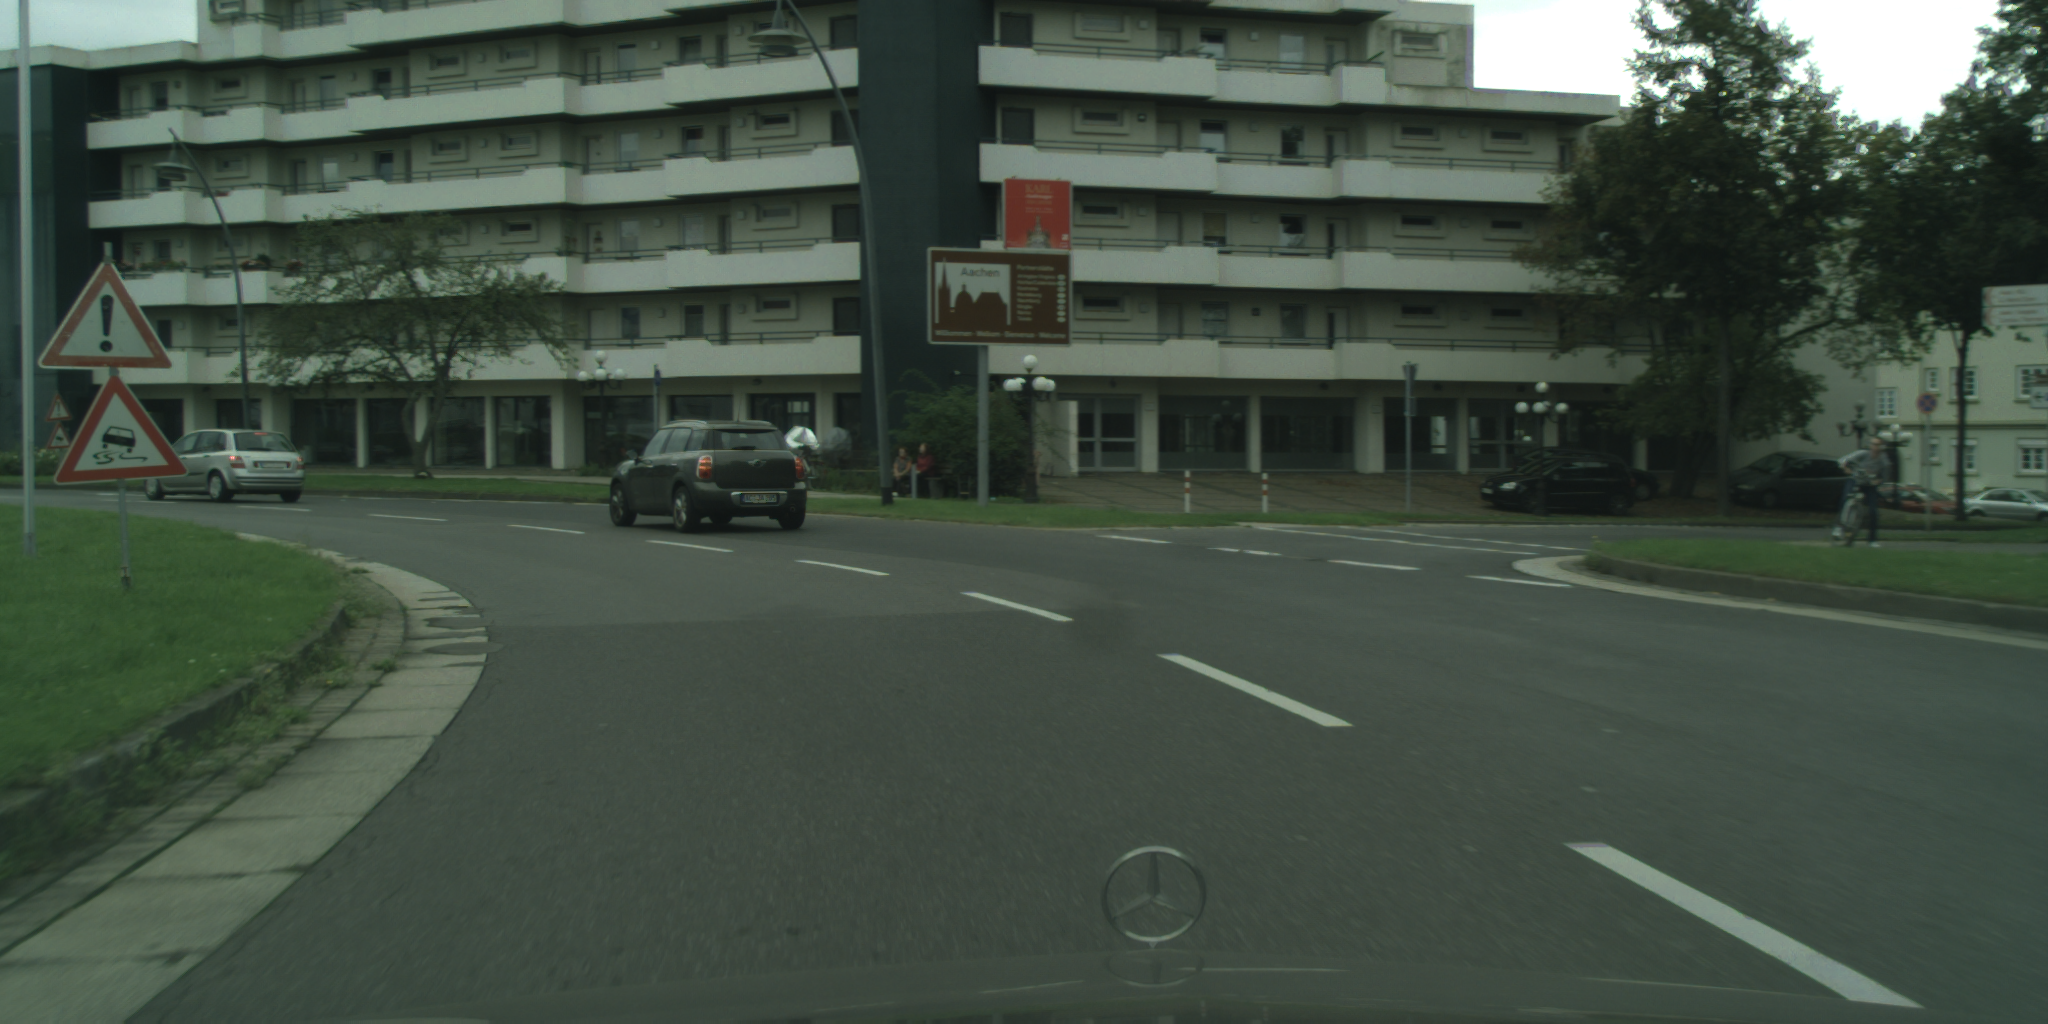

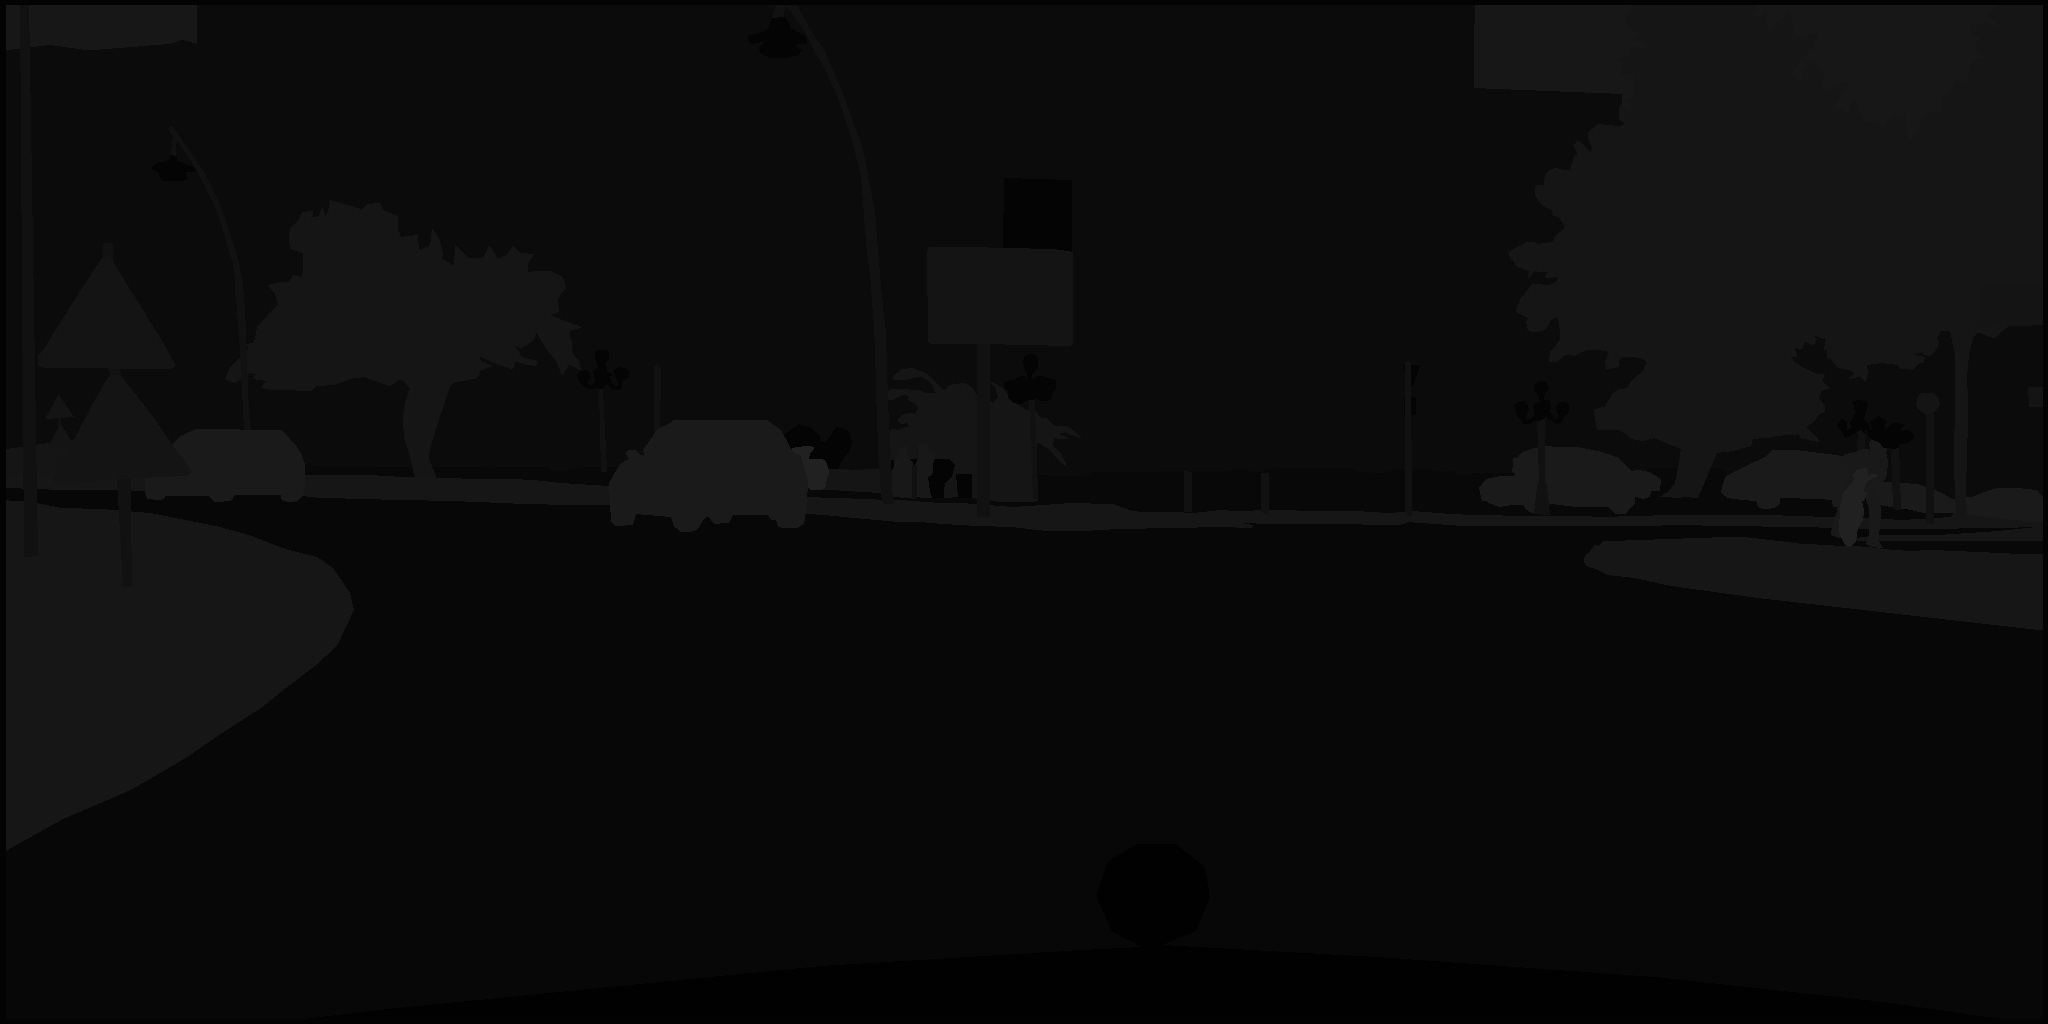

In [5]:
display(Image(filename=train_img_paths[0]))
display(Image(filename=train_ann_paths[0]))

### Dèfinir différente paramètres

In [6]:
img_size = (128 , 128)
num_classes = 8
batch_size = 2975
imgaug_multiplier = 1
epochs = 10
patience = 5
AUTO = tf.data.AUTOTUNE

### Dèfinir les fonctions me permettant de passer de 32 sous catégories à seulement 8 catégories

In [7]:
cats = {
 'void': [0, 1, 2, 3, 4, 5, 6],
 'flat': [7, 8, 9, 10],
 'construction': [11, 12, 13, 14, 15, 16],
 'object': [17, 18, 19, 20],
 'nature': [21, 22],
 'sky': [23],
 'human': [24, 25],
 'vehicle': [26, 27, 28, 29, 30, 31, 32, 33, -1]}

def convertCats(x):
    if x in cats['void']:
        return 0
    elif x in cats['flat']:
        return 1
    elif x in cats['construction']:
        return 2
    elif x in cats['object']:
        return 3
    elif x in cats['nature']:
        return 4
    elif x in cats['sky']:
        return 5
    elif x in cats['human']:
        return 6
    elif x in cats['vehicle']:
        return 7
    
convertCats_v = np.vectorize(convertCats)

def preprocessImg(img):
    image_matrix = np.expand_dims(img, 2)
    
    converted_image = convertCats_v(image_matrix)
    return converted_image

### Réaliser le gènèrateur de données

In [8]:
class Image(Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        
        x = np.zeros((self.batch_size * imgaug_multiplier,) + self.img_size + (3,), dtype="uint8")        
        for j, path in enumerate(batch_input_img_paths):
            img = image.load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size * imgaug_multiplier,) + self.img_size+ (1,), dtype="uint8")

        for j, path in enumerate(batch_target_img_paths):
            _img = image.load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = preprocessImg(_img)
                
        return x, y

### Gènérer les images

In [9]:
train_seq = Image(
    batch_size, img_size, train_img_paths, train_ann_paths
)

### Vérifier la correspondance des images avec leurs masques respectifs

In [10]:
#assert train_seq[0][0].shape == (batch_size * imgaug_multiplier, *img_size, 3)
#assert train_seq[0][1].shape == (batch_size * imgaug_multiplier, *img_size,1)

### Extraire les variables images et masques puis vérifier la forme

In [11]:
for x, y in train_seq:
    break
x.shape, y.shape

((2975, 128, 128, 3), (2975, 128, 128, 1))

### Contrôler le nombre maximal de pixel contenue dans la variable image

In [12]:
print("Valeurs max pixels image: ", x.max())

Valeurs max pixels image:  255


### Contrôler le nombre de catègories prèsents dans la variable masque

In [13]:
print("Valeurs pixels mask: ", np.unique(y))

Valeurs pixels mask:  [0 1 2 3 4 5 6 7]


### Normaliser les images

In [14]:
image_dataset = x/255.  

### Fractionner mes images et mes masques en jeu d'entrainement et de test

In [15]:
X_train, X_test, y_train, y_test = train_test_split(image_dataset, y, test_size = 0.2, random_state = 42)

### Etablir les 8 canaux de sortie avec conversion catègoriel de notre y_train et y_test(afin d'obtenir le bon format d'entrèe)

In [16]:
train_masks_cat = to_categorical(y_train, num_classes=num_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], num_classes))

test_masks_cat = to_categorical(y_test, num_classes=num_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], num_classes))

print("Format entrée label entrainement:",y_train_cat.shape)
print("Format entrée label test:",y_test_cat.shape)

Format entrée label entrainement: (2380, 128, 128, 8)
Format entrée label test: (595, 128, 128, 8)


### Construire Unet en divisant l’encodeur et le décodeur en blocs

In [17]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network. 
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x

### Bloc encodeur: conv_block suivi de maxpooling

In [18]:
def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p 

### Bloc décodeur (Les fonctions de saut obtiennent l’entrée de l’encodeur pour la concaténation)

In [19]:
def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

### Construire Unet en utilisant les blocs

In [20]:
def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    if n_classes == 1: 
        activation = 'sigmoid'
    else:
        activation = 'softmax'

    outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d4)  #Change the activation based on n_classes
    print(activation)

    model = Model(inputs, outputs, name="U-Net")
    return model

### Dèfinir la variable d'entrèe input_shape de mon modèle 

In [21]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

### Construire mon modèle

In [22]:
model = build_unet(input_shape, n_classes=8)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

softmax
Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                     

### Entaîner mon modèle

In [23]:
history = model.fit(X_train, y_train_cat, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=60, 
                    validation_data=(X_test, y_test_cat), 
                    shuffle=False)

Epoch 1/60
149/149 [==============================] - 142s 553ms/step - loss: 0.6646 - accuracy: 0.7927 - val_loss: 3.3160 - val_accuracy: 0.4881
Epoch 2/60
149/149 [==============================] - 75s 506ms/step - loss: 0.4915 - accuracy: 0.8441 - val_loss: 1.0724 - val_accuracy: 0.6589
Epoch 3/60
149/149 [==============================] - 76s 510ms/step - loss: 0.4508 - accuracy: 0.8566 - val_loss: 0.8772 - val_accuracy: 0.7317
Epoch 4/60
149/149 [==============================] - 76s 513ms/step - loss: 0.4139 - accuracy: 0.8685 - val_loss: 0.5687 - val_accuracy: 0.8347
Epoch 5/60
149/149 [==============================] - 77s 515ms/step - loss: 0.3902 - accuracy: 0.8757 - val_loss: 0.4257 - val_accuracy: 0.8689
Epoch 6/60
149/149 [==============================] - 77s 517ms/step - los

### Enregistrer le modèle pour une utilisation ultérieure

In [24]:
model.save('model_simple_unet.h5')

### Tracer la précision et la perte de formation et de validation à chaque époque

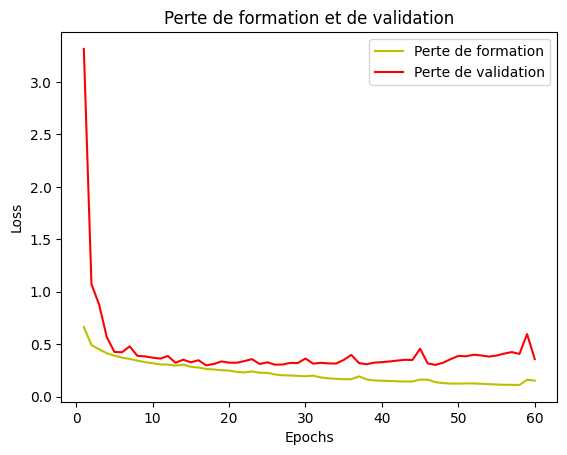

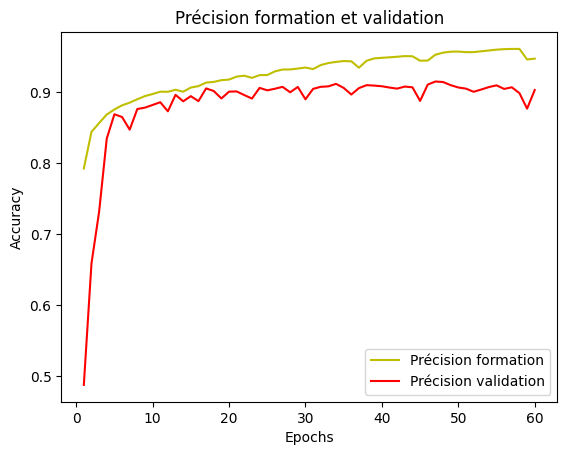

In [25]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Perte de formation')
plt.plot(epochs, val_loss, 'r', label='Perte de validation')
plt.title('Perte de formation et de validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Précision formation')
plt.plot(epochs, val_acc, 'r', label='Précision validation')
plt.title('Précision formation et validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Charger le modèle précédemment enregistré

In [26]:
model = load_model('model_simple_unet.h5', compile=False)

### Prédiction sur les données test

In [27]:
y_pred=model.predict(X_test)
y_pred.shape

(595, 128, 128, 8)

In [28]:
y_pred_argmax=np.argmax(y_pred, axis=3)
y_pred_argmax.shape

(595, 128, 128)

Celà me permet d'avoir une forme pour calculer l'IOU

### Utilisation de la fonction keras intégrée

In [29]:
n_classes = 8
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Moyenne IoU =", IOU_keras.result().numpy())

Moyenne IoU = 0.69705814


En utilisant la mètrique de keras MeanIoU instancie la moyenne IOU puis met à jours l'état des résultats de la prédiction des masques que j'ai obtenu sur les données test en le comparant au label de l'image  

### Pour calculer I0U pour chaque classe (affichage de la matrice)

Type de matrice de confusion 

In [30]:
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)

[[7.439650e+05 9.443300e+04 9.706100e+04 7.009000e+03 1.998600e+04
  1.334000e+03 4.824000e+03 5.133000e+03]
 [2.091200e+04 3.740107e+06 2.393800e+04 1.668000e+03 1.319000e+04
  0.000000e+00 3.575000e+03 6.754000e+03]
 [1.993700e+04 1.251500e+04 2.009298e+06 1.079000e+04 6.833200e+04
  1.750000e+03 6.261000e+03 7.213000e+03]
 [1.113300e+04 3.503000e+03 7.433300e+04 5.577800e+04 2.000300e+04
  6.250000e+02 3.405000e+03 1.580000e+03]
 [7.439000e+03 1.557500e+04 1.090090e+05 5.326000e+03 1.330431e+06
  3.893000e+03 1.243000e+03 2.745000e+03]
 [1.796000e+03 2.000000e+00 4.795400e+04 1.381000e+03 5.606000e+03
  2.968700e+05 2.400000e+01 1.210000e+02]
 [7.487000e+03 5.570000e+03 2.495200e+04 1.820000e+03 3.544000e+03
  4.000000e+00 7.503100e+04 4.023000e+03]
 [3.263200e+04 2.508000e+04 6.921500e+04 2.686000e+03 1.323000e+04
  6.400000e+01 1.113200e+04 5.522500e+05]]


In [31]:
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[0,4] + values[0,5] 
                          + values[0,6] + values[0,7] + values[1,0]+ values[2,0]+ values[3,0]+ values[4,0] 
                          + values[5,0] + values[6,0] + values[7,0])

class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[1,4] + values[1,5] 
                          + values[1,6] + values[1,7] + values[0,1]+ values[2,1]+ values[3,1]+ values[4,1] 
                          + values[5,1] + values[6,1] + values[7,1])

class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[2,4] + values[2,5] 
                          + values[2,6] + values[2,7] + values[0,2]+ values[1,2]+ values[3,2]+ values[4,2] 
                          + values[5,2] + values[6,2] + values[7,2])

class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[3,4] + values[3,5] 
                          + values[3,6] + values[3,7] + values[0,3]+ values[1,3]+ values[2,3]+ values[4,3] 
                          + values[5,3] + values[6,3] + values[7,3])

class5_IoU = values[4,4]/(values[4,4] + values[4,0] + values[4,1] + values[4,2] + values[4,3] + values[4,5] 
                          + values[4,6] + values[4,7] + values[0,4]+ values[1,4]+ values[2,4]+ values[3,4] 
                          + values[5,4] + values[6,4] + values[7,4])

class6_IoU = values[5,5]/(values[5,5] + values[5,0] + values[5,1] + values[5,2] + values[5,3] + values[5,4] 
                          + values[5,6] + values[5,7] + values[0,5]+ values[1,5]+ values[2,5]+ values[3,5] 
                          + values[4,5] + values[6,5] + values[7,5])

class7_IoU = values[6,6]/(values[6,6] + values[6,0] + values[6,1] + values[6,2] + values[6,3] + values[6,4] 
                          + values[6,5] + values[6,7] + values[0,6]+ values[1,6]+ values[2,6]+ values[3,6] 
                          + values[4,6] + values[5,6] + values[7,6])

class8_IoU = values[7,7]/(values[7,7] + values[7,0] + values[7,1] + values[7,2] + values[7,3] + values[7,4] 
                          + values[7,5] + values[7,6] + values[0,7]+ values[1,7]+ values[2,7]+ values[3,7] 
                          + values[4,7] + values[5,7] + values[6,7])

print("IoU pour void est: ", class1_IoU)
print("IoU pour flat est: ", class2_IoU)
print("IoU pour construction est: ", class3_IoU)
print("IoU pour objet est: ", class4_IoU)
print("IoU pour nature est: ", class5_IoU)
print("IoU pour sky est: ", class6_IoU)
print("IoU pour human est: ", class7_IoU)
print("IoU pour vehicle est: ", class8_IoU)

IoU pour void est:  0.6920083
IoU pour flat est:  0.9428472
IoU pour construction est:  0.7780263
IoU pour objet est:  0.27744728
IoU pour nature est:  0.8214809
IoU pour sky est:  0.82138985
IoU pour human est:  0.49073547
IoU pour vehicle est:  0.7525298


### Prédire sur première image

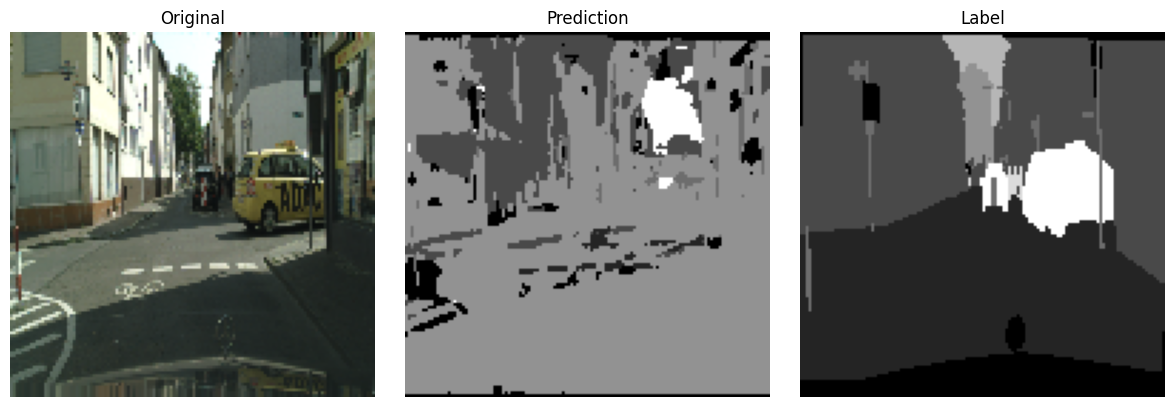

In [32]:
img = load_img('jk/P8_Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/val/frankfurt/frankfurt_000000_000294_leftImg8bit.png', target_size=(128, 128))
mask = load_img('jk/P8_Cityscapes_gtFine_trainvaltest/gtFine/val/frankfurt/frankfurt_000000_000294_gtFine_labelIds.png', target_size=(128, 128), color_mode="grayscale") 
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
x= x/255.
prediction = model.predict(x)
predicted_img=np.argmax(prediction, axis=3)[0,:,:]
y = preprocessImg(mask)[:,:,0]

plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.title("Original")
plt.imshow(img)
plt.axis("off")
    
plt.subplot(132)
plt.title("Prediction")
plt.imshow(predicted_img, cmap='gray')
plt.axis("off")
    
plt.subplot(133)
plt.title("Label")
plt.imshow(y, cmap='gray')
plt.axis("off")
plt.tight_layout()
plt.show()

### Prédire sur la seconde image

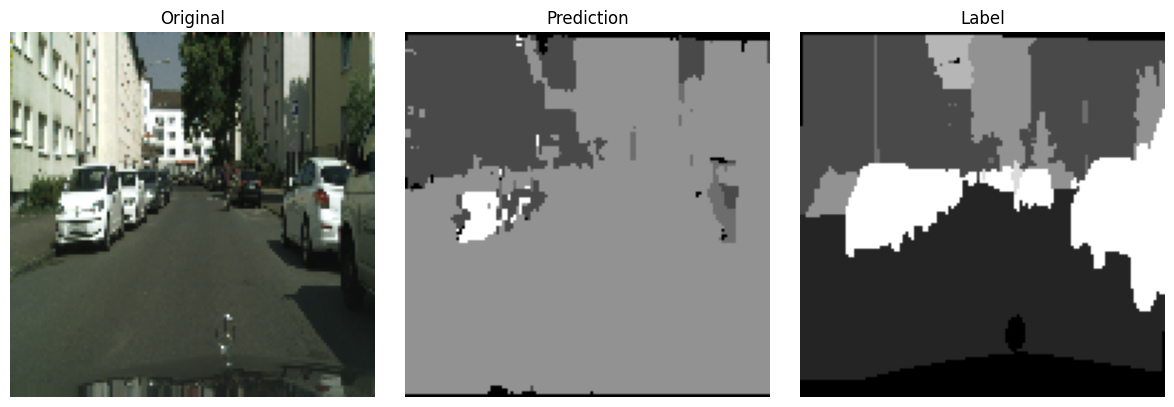

In [33]:
img = load_img('jk/P8_Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/val/frankfurt/frankfurt_000000_000576_leftImg8bit.png', target_size=(128, 128))
mask = load_img('jk/P8_Cityscapes_gtFine_trainvaltest/gtFine/val/frankfurt/frankfurt_000000_000576_gtFine_labelIds.png', target_size=(128, 128), color_mode="grayscale") 
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
x= x/255.
prediction = model.predict(x)
predicted_img=np.argmax(prediction, axis=3)[0,:,:]
y = preprocessImg(mask)[:,:,0]

plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.title("Original")
plt.imshow(img)
plt.axis("off")
    
plt.subplot(132)
plt.title("Prediction")
plt.imshow(predicted_img, cmap='gray')
plt.axis("off")
    
plt.subplot(133)
plt.title("Label")
plt.imshow(y, cmap='gray')
plt.axis("off")
plt.tight_layout()
plt.show()

### Prédire sur la troisième image

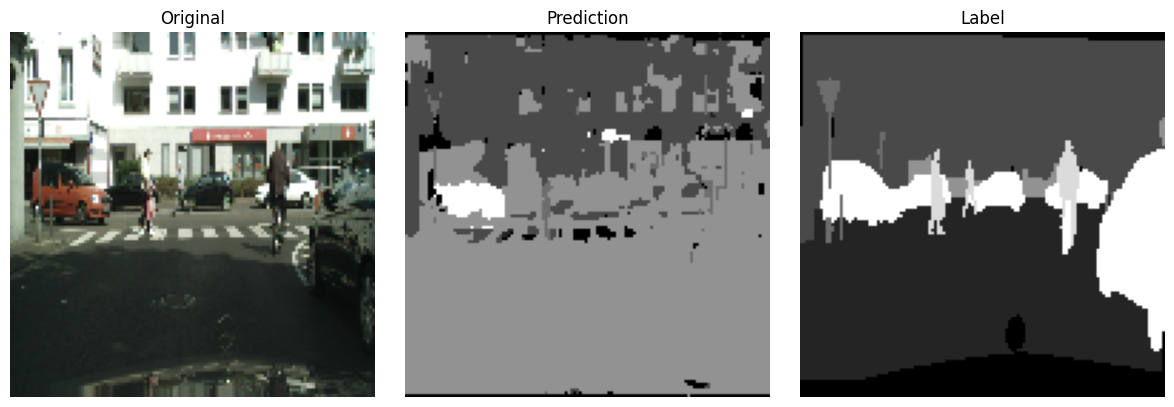

In [34]:
img = load_img('jk/P8_Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/val/frankfurt/frankfurt_000000_001016_leftImg8bit.png', target_size=(128, 128))
mask = load_img('jk/P8_Cityscapes_gtFine_trainvaltest/gtFine/val/frankfurt/frankfurt_000000_001016_gtFine_labelIds.png', target_size=(128, 128), color_mode="grayscale") 
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
x= x/255.
prediction = model.predict(x)
predicted_img=np.argmax(prediction, axis=3)[0,:,:]
y = preprocessImg(mask)[:,:,0]

plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.title("Original")
plt.imshow(img)
plt.axis("off")
    
plt.subplot(132)
plt.title("Prediction")
plt.imshow(predicted_img, cmap='gray')
plt.axis("off")
    
plt.subplot(133)
plt.title("Label")
plt.imshow(y, cmap='gray')
plt.axis("off")
plt.tight_layout()
plt.show()

### Prédire sur la quatrième image

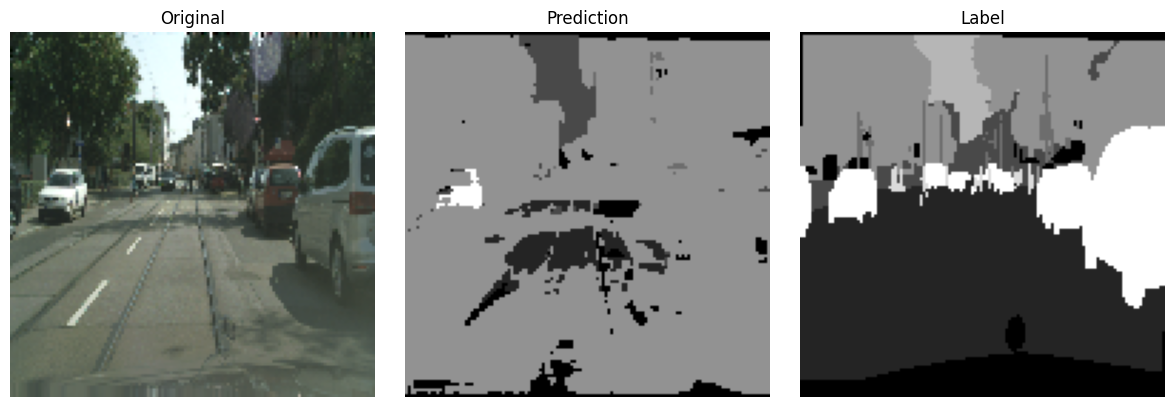

In [35]:
img = load_img('jk/P8_Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/val/frankfurt/frankfurt_000000_001236_leftImg8bit.png', target_size=(128, 128))
mask = load_img('jk/P8_Cityscapes_gtFine_trainvaltest/gtFine/val/frankfurt/frankfurt_000000_001236_gtFine_labelIds.png', target_size=(128, 128), color_mode="grayscale") 
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
x= x/255.
prediction = model.predict(x)
predicted_img=np.argmax(prediction, axis=3)[0,:,:]
y = preprocessImg(mask)[:,:,0]

plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.title("Original")
plt.imshow(img)
plt.axis("off")
    
plt.subplot(132)
plt.title("Prediction")
plt.imshow(predicted_img, cmap='gray')
plt.axis("off")
    
plt.subplot(133)
plt.title("Label")
plt.imshow(y, cmap='gray')
plt.axis("off")
plt.tight_layout()
plt.show()